### Задание
Попробуйте поэкспериментировать со следующими параметрами нейронной сети:<br> 
<br> 
* Для полносвязной сети:<br>
    * кол-во слоев нейронной сети <br> 
    * кол-во нейронов в каждом слое <br>
    * функции активации на промежуточных слоях <br> 
<br>
* Для сверточной сети:<br>
    * кол-во фильтров в сверточном слое <br>
    * размер фильтра в сверточном слое <br>
    * размер окна в пулинг слое. <br>
<br>
1.  Обучите нейронную сеть (полносвязную и сверточную) пробуя разные комбинации перечисленных выше параметров, <br> 
2. Составьте таблицу с зависимость точности нейронной сети на обучающих и тестовых данных, от значения параметра, <br>
3. Напишите Ваши выводы о том, как тот или иной параметр влияет на точность обучения нейронной сети.

### Import & Util functions

#### Import

In [1]:
from genericpath import exists

import numpy as np                  
import matplotlib.pyplot as plt      
import random                        

from keras.datasets import mnist     # MNIST dataset 
from keras.models import Sequential  # Model Нейронной сети

from keras.layers.core import Dense, Dropout, Activation # Функции Активации и Слои нейронной сети
from keras.utils import np_utils 

from keras.models import load_model

2022-10-17 00:20:04.149164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 00:20:04.516981: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-17 00:20:04.647944: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 00:20:05.868341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

#### Вспомогательная функция для расчета и вывода метрик

In [2]:
import sklearn
from sklearn import metrics
def calcMetrics(y_predict, y_true):
    return [metrics.accuracy_score(y_true, y_predict),
            metrics.precision_score(y_true, y_predict, average='weighted', zero_division=0),
            metrics.recall_score(y_true, y_predict, average='weighted', zero_division=0),
            metrics.f1_score(y_true, y_predict, average='weighted', zero_division=0)]
def printMetrics(m):
    print(f"Accuracy = {m[0]}, Precision = {m[1]}, Recall = {m[2]}, F1 = {m[3]}")

In [24]:
def getModelAccuracyStr(model, X_train, X_test, y_train, y_test):
    predictTrain = model.predict(X_train, verbose=0)
    predictTrain = np.argmax(predictTrain, axis=1)
    predictTest = model.predict(X_test, verbose=0)
    predictTest = np.argmax(predictTest, axis=1)
    train_accuracy = metrics.accuracy_score(y_train, predictTrain)
    test_accuracy = metrics.accuracy_score(y_test, predictTest)
    return [np.round(train_accuracy, decimals=3), np.round(test_accuracy, decimals=3)]

#### Вспомогательная функция для вывода таблицы по классам и корреляционной матрицы

In [4]:
import matplotlib
import pandas as pd
from matplotlib.pyplot import title, xlabel, ylabel
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

dfMetricsCols = ['Accuracy', 'Precision', 'Recall', 'F1']
dfConfCols = ['True Positive', 'True Negative', 'False Positive']
def setDfRow(dfMetrics, dfConf, i, cmat, y_predict, y_true):
    i_cmat = i - 1
    dfMetrics.iloc[i][0], dfMetrics.iloc[i][1], dfMetrics.iloc[i][2], dfMetrics.iloc[i][3] =  calcMetrics(y_predict, y_true)

    if i == 0: # для строки Total
        dfConf.iloc[i][0] = np.sum(cmat.diagonal())
        dfConf.iloc[i][1] = np.sum(np.ravel(cmat)) - np.sum(np.ravel(cmat.diagonal())) - np.sum(np.ravel(np.tril(cmat, -1)))
        dfConf.iloc[i][2] = np.sum(np.ravel(np.tril(cmat, -1)))
    else: # для строк с конкретными буквами
        dfConf.iloc[i][0] = cmat[i_cmat][i_cmat]
        dfConf.iloc[i][1] = np.sum(cmat[i_cmat]) - cmat[i_cmat][i_cmat]
        dfConf.iloc[i][2] = np.sum(cmat[i_cmat]) - cmat[i_cmat][i_cmat]

def plotCorr(fig, ax, y_predict, y_true):
    cmat = confusion_matrix(y_true, y_predict)
    class_dict = [chr(i) for i in range(48, 48+10)]

    plot_confusion_matrix(
        conf_mat=cmat,
        class_names=class_dict,
        colorbar=True,
        figure=fig,
        axis=ax
    )
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')

    indexDf = np.array(['Total'])
    indexDf = np.append(indexDf, class_dict)
    dfConf = pd.DataFrame(index=indexDf, columns=dfConfCols)
    dfMetrics = pd.DataFrame(index=indexDf, columns=dfMetricsCols)

    setDfRow(dfMetrics, dfConf, 0, cmat, y_predict, y_true) # row for total val

    for i_val, c in enumerate(class_dict):
        i = i_val + 1
        classIndexes = np.where(y_true == i_val)
        y_class = y_predict[classIndexes]
        y_check = y_true[classIndexes]
        
        setDfRow(dfMetrics, dfConf, i, cmat, y_class, y_check)

    return dfMetrics, dfConf

#### Вспомогательная функция для именования save/load файлов

In [5]:
def getModelPathById(id, sType):
    return f"model_{sType}.{id}"

### Скачиваем датасет

In [6]:
#  60,000 28 x 28 pixel тренировочные изображения и  10,000 28 x 28 pixel тестовые изображения
(X_train_original, y_train_original), (X_test_original, y_test_original) = mnist.load_data()

print("X_train shape", X_train_original.shape)
print("y_train shape", y_train_original.shape)
print("X_test shape", X_test_original.shape)
print("y_test shape", y_test_original.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


#### Выводим пример данных

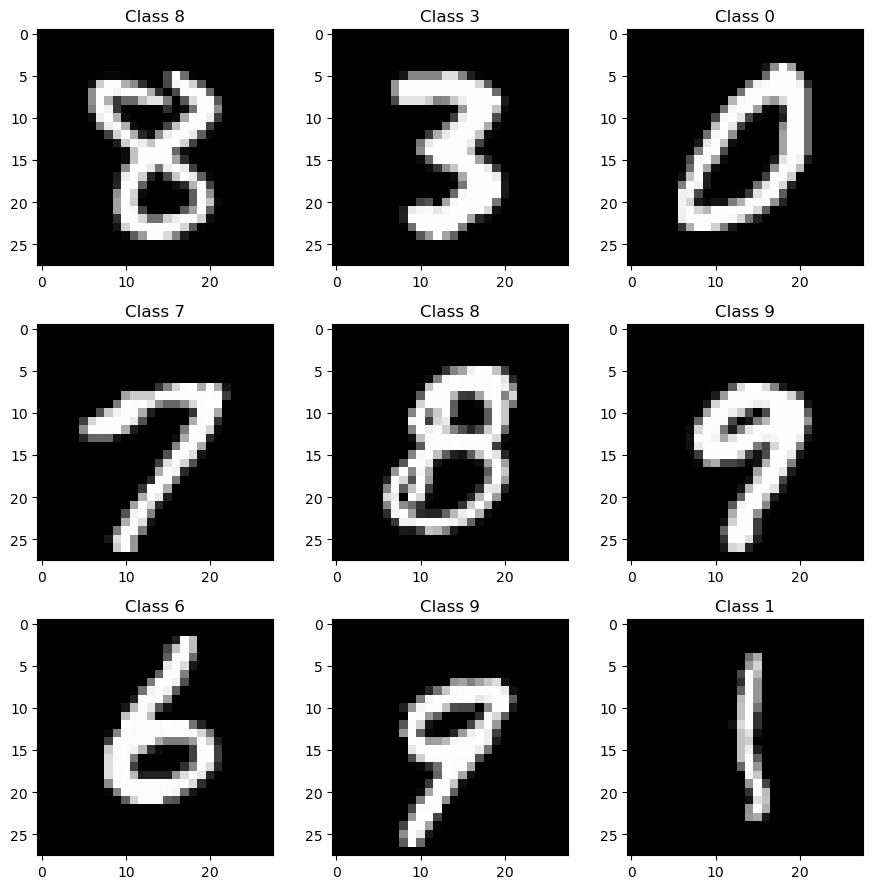

In [7]:
plt.rcParams['figure.figsize'] = (9,9) 

for i in range(9):
    plt.subplot(3, 3, i+1)
    num = random.randint(0, len(X_train_original))

    plt.imshow(X_train_original[num], cmap='gray', interpolation='none')
    plt.title(f"Class {y_train_original[num]}")
    
plt.tight_layout()

In [13]:
# one-hot формат
nb_classes = 10 # Кол-во классов (всего 10 цифр)

Y_train = np_utils.to_categorical(y_train_original, nb_classes)
Y_test = np_utils.to_categorical(y_test_original, nb_classes)

### Модель полносвязной нейронной сети

#### Подготовка данных для НН

In [7]:
# вытягиваем в вектора
X_train = X_train_original.reshape(60000, 784) 
X_test = X_test_original.reshape(10000, 784)   

# конертируем в float
X_train = X_train.astype('float32')   
X_test = X_test.astype('float32')

X_train /= 255                       
X_test /= 255

#### Модель

In [9]:
def createFCN(nLayer = 2, nNeuron = 512, sActivationFn = 'relu'):
    model_FCN = Sequential()

    for layer in range(nLayer):
        model_FCN.add(Dense(nNeuron, input_shape=(784 if layer == 0 else nNeuron,))) 
        model_FCN.add(Activation(sActivationFn))
        model_FCN.add(Dropout(0.2)) # Dropout - это аналог регуляризации в нейронных сетях

    # Последний уровень FCN должен быть равен количеству желаемых классов (в данном случае 10).
    model_FCN.add(Dense(10))
    model_FCN.add(Activation('softmax'))

    # /* Сборка модели */ 
    # Keras построен на основе Theano и TensorFlow. Оба пакета позволяют вам определять граф вычислений в Python,
    # который затем компилируется и эффективно запускается на CPU или GPU без дополнительных затрат на интерпретатор Python.
    #
    # При составлении модели Keras просит вас указать вашу функцию потерь и ваш оптимизатор. 
    # Функция потерь, которую мы здесь будем использовать, называется категориальной кросс-энтропией и является функцией потерь, 
    # хорошо подходящей для сравнения двух распределений вероятностей.
    #
    # Оптимизатор помогает определить, насколько быстро модель обучается с помощью градиентного спуска. 
    # Скорость, с которой сходится градиент, называется скоростью обучения.
    model_FCN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model_FCN

#### Варьирование параметров

In [18]:
params_FCN = {
    "nLayer" : range(1, 5),
    "nNeuron" : [32, 64, 128, 256, 512, 1024],
    "sActivationFn" : ["relu", "sigmoid", "tanh"]
}

#### Обучение

batch_size определяет, сколько данных на шаг используется для вычисления функции потерь, градиентов и обратного распространения. Большие размеры пакетов позволяют сети быстрее завершить обучение; Однако следует учитывать и другие факторы, помимо скорости тренировки.

Слишком большой размер batch_size пакета сглаживает локальные минимумы функции потерь, в результате чего оптимизатор застревает в Локальном минимуме.
Слишком маленький размер batch_siz пакета создает очень "зашумленную" функцию потерь, и оптимизатор может никогда не найти глобальный минимум.

epochs - количество итераций над каждым примером
verbose - вывод текстового прогресс бара 

In [21]:
iModel = 0

for nLayer in params_FCN['nLayer']:
    for nNeuron in params_FCN['nNeuron']:
        for sActivationFn in params_FCN['sActivationFn']:
            currentPath = getModelPathById(iModel, "FCN")
            if not exists(currentPath):
                model_FCN = createFCN(nLayer, nNeuron, sActivationFn)
                model_FCN.fit(X_train, Y_train,
                        batch_size=32, epochs=10,
                        verbose=0)
                        
                model_FCN.save(currentPath)
                del model_FCN

            iModel += 1

========= nLayer = 1 =========
======  nNeuron = 32 ======
===  sActivationFn = relu ===
Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4823 - accuracy: 0.8576
Epoch 2/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.2884 - accuracy: 0.9148
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2490 - accuracy: 0.9251
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2271 - accuracy: 0.9312
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2134 - accuracy: 0.9347
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2026 - accuracy: 0.9373
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1920 - accuracy: 0.9414
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1871 - accuracy: 0.9415
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1818 - accuracy:

#### Таблица accuracy

In [106]:
iModel = 0

accTablesFCN = []

print("Точность на обучающей/тестовой выборке\n")
for sActivationFn in params_FCN['sActivationFn']:
    print(f"Активационная функция - '{sActivationFn}'")
    columns = ["Кол-во слоёв"]
    columns.extend(f"Кол-во нейронов {x}" for x in params_FCN["nNeuron"])
    accuracy_table = pd.DataFrame(columns=columns)
    for iLayer, nLayer in enumerate(params_FCN['nLayer']):
        accuracy_row = [str(nLayer)]
        for nNeuron in params_FCN['nNeuron']:
            model = load_model(getModelPathById(iModel, "FCN"))
            accuracy_row.append(getModelAccuracyStr(model, X_train, X_test, y_train_original, y_test_original))
            iModel += 1
        accuracy_table.loc[nLayer] = accuracy_row
    accuracy_table.set_index("Кол-во слоёв")
    display(accuracy_table)
    accTablesFCN.append(accuracy_table)

Точность на обучающей/тестовой выборке

Активационная функция - 'relu'


,Кол-во слоёв,Кол-во нейронов 32,Кол-во нейронов 64,Кол-во нейронов 128,Кол-во нейронов 256,Кол-во нейронов 512,Кол-во нейронов 1024
1,1,"[0.972, 0.963]","[0.965, 0.953]","[0.968, 0.958]","[0.989, 0.975]","[0.98, 0.97]","[0.983, 0.969]"
2,2,"[0.994, 0.978]","[0.989, 0.976]","[0.991, 0.976]","[0.997, 0.983]","[0.994, 0.98]","[0.995, 0.978]"
3,3,"[0.996, 0.98]","[0.996, 0.983]","[0.994, 0.978]","[0.997, 0.981]","[0.998, 0.982]","[0.995, 0.98]"
4,4,"[0.971, 0.961]","[0.959, 0.954]","[0.969, 0.959]","[0.987, 0.973]","[0.979, 0.969]","[0.983, 0.972]"


Активационная функция - 'sigmoid'


,Кол-во слоёв,Кол-во нейронов 32,Кол-во нейронов 64,Кол-во нейронов 128,Кол-во нейронов 256,Кол-во нейронов 512,Кол-во нейронов 1024
1,1,"[0.994, 0.978]","[0.99, 0.978]","[0.989, 0.975]","[0.991, 0.978]","[0.995, 0.982]","[0.994, 0.978]"
2,2,"[0.996, 0.982]","[0.997, 0.981]","[0.993, 0.978]","[0.994, 0.981]","[0.996, 0.982]","[0.986, 0.974]"
3,3,"[0.968, 0.96]","[0.958, 0.952]","[0.965, 0.956]","[0.985, 0.974]","[0.977, 0.963]","[0.981, 0.97]"
4,4,"[0.992, 0.979]","[0.989, 0.978]","[0.988, 0.973]","[0.993, 0.98]","[0.994, 0.981]","[0.992, 0.978]"


Активационная функция - 'tanh'


,Кол-во слоёв,Кол-во нейронов 32,Кол-во нейронов 64,Кол-во нейронов 128,Кол-во нейронов 256,Кол-во нейронов 512,Кол-во нейронов 1024
1,1,"[0.993, 0.979]","[0.994, 0.981]","[0.989, 0.976]","[0.992, 0.98]","[0.996, 0.982]","[0.982, 0.973]"
2,2,"[0.969, 0.96]","[0.947, 0.939]","[0.965, 0.955]","[0.983, 0.973]","[0.974, 0.963]","[0.979, 0.968]"
3,3,"[0.99, 0.979]","[0.987, 0.974]","[0.988, 0.976]","[0.992, 0.981]","[0.992, 0.978]","[0.987, 0.973]"
4,4,"[0.993, 0.98]","[0.993, 0.979]","[0.986, 0.976]","[0.992, 0.98]","[0.994, 0.979]","[0.974, 0.966]"


#### Выводы

### Модель сверточной нейронной сети

#### Подготовка данных для НН

In [8]:
X_train_px = X_train_original.reshape(60000, 28, 28, 1) 
X_test_px = X_test_original.reshape(10000, 28, 28, 1)

X_train_px = X_train_px.astype('float32')         
X_test_px = X_test_px.astype('float32')

X_train_px /= 255                              
X_test_px /= 255

print("Training matrix shape", X_train_px.shape)
print("Testing matrix shape", X_test_px.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [9]:
# import 
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers.normalization.batch_normalization import BatchNormalization

#### Модель

In [10]:
def createCN(nFilter, nKernal, nPool, nLayer, nNeuron, sActivationFn):
    model = Sequential()                                 
    kernalSize = (nKernal, nKernal)
    poolSize = (nPool, nPool)

    # Сверточный слой 1
    model.add(Conv2D(nFilter, kernalSize, input_shape=(28,28,1)))
    model.add(BatchNormalization(axis=-1))                
    model.add(Activation('relu'))

    # Сверточный слой 2
    model.add(Conv2D(nFilter, kernalSize))                        
    model.add(BatchNormalization(axis=-1))               
    model.add(Activation('relu'))                        
    model.add(MaxPooling2D(pool_size=poolSize)) # MaxPool операция 2x2 kernel

    # Сверточный слой 3
    model.add(Conv2D(2 * nFilter, kernalSize))                         # 64 РАЗНЫХ! 3x3 kernels -- so 64 feature maps
    model.add(BatchNormalization(axis=-1))              
    model.add(Activation('relu'))

    # Сверточный слой 4
    model.add(Conv2D(2 * nFilter, kernalSize))                        
    model.add(BatchNormalization(axis=-1))               
    model.add(Activation('relu'))                        # activation
    model.add(MaxPooling2D(pool_size=poolSize)) # MaxPool операция 2x2 kernel
    model.add(Flatten())                                 # Разворачиваем матрицу 4x4x64 в 1024-мерный плоский вектор

    # Полносвязные слои
    for layer in range(nLayer):
        model.add(Dense(nNeuron))
        model.add(BatchNormalization(axis=-1))                
        model.add(Activation(sActivationFn))
        model.add(Dropout(0.2)) # Dropout - это аналог регуляризации в нейронных сетях

    # Последний уровень FCN должен быть равен количеству желаемых классов (в данном случае 10).
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

#### Варьирование параметров

In [38]:
params_CN = {
    # Параметры свёрточных слоёв
    "nFilter" : [16, 32, 64],
    "nKernalAndPool" : [(2,2), (2,3), (2,4), (3,2), (3,3), (4,2)],

    # Параметры полносвязных слоёв
    "nLayer" : range(1, 4),
    "nNeuron" : [256, 512, 1024],
    "sActivationFn" : ["relu", "sigmoid", "tanh"]
}

#### Проверяем зависимость влияния параметров в свёрточных слоях, параметры полносвязных слоев зафиксированы на наилучшем из прошлого экспиримента

In [14]:
iModel = 0

nLayer, nNeuron, sActivationFn = 2, 512, 'relu'

for nFilter in params_CN['nFilter']:
    for nKernal, nPool in params_CN['nKernalAndPool']:
            currentPath = getModelPathById(iModel, "CN_conv")
            if not exists(currentPath):
                print(f"nFilter = {nFilter}, (nKernal, nPool) = ({nKernal},{nPool})")
                model_CN = createCN(nFilter, nKernal, nPool, nLayer, nNeuron, sActivationFn)
                model_CN.fit(X_train_px, Y_train,
                        batch_size=32, epochs=10,
                        verbose=0)
                        
                model_CN.save(currentPath)
                del model_CN

            iModel += 1

nFilter = 16, (nKernal, nPool) = (2,2)


2022-10-17 00:21:31.734659: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-17 00:21:33.222316: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-17 00:21:33.307142: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-17 00:21:33.307203: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-10-17 00:21:33.386532: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-17 00:21:33.386908: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-10-17 00:21:34.671959: I tensorflow/stream_executor/cuda/c

INFO:tensorflow:Assets written to: model_CN_conv.0/assets


INFO:tensorflow:Assets written to: model_CN_conv.0/assets


nFilter = 16, (nKernal, nPool) = (2,3)


INFO:tensorflow:Assets written to: model_CN_conv.1/assets


INFO:tensorflow:Assets written to: model_CN_conv.1/assets


nFilter = 16, (nKernal, nPool) = (2,4)


INFO:tensorflow:Assets written to: model_CN_conv.2/assets


INFO:tensorflow:Assets written to: model_CN_conv.2/assets


nFilter = 16, (nKernal, nPool) = (3,2)


INFO:tensorflow:Assets written to: model_CN_conv.3/assets


INFO:tensorflow:Assets written to: model_CN_conv.3/assets


nFilter = 16, (nKernal, nPool) = (3,3)


INFO:tensorflow:Assets written to: model_CN_conv.4/assets


INFO:tensorflow:Assets written to: model_CN_conv.4/assets


nFilter = 16, (nKernal, nPool) = (4,2)


INFO:tensorflow:Assets written to: model_CN_conv.5/assets


INFO:tensorflow:Assets written to: model_CN_conv.5/assets


nFilter = 32, (nKernal, nPool) = (2,2)


INFO:tensorflow:Assets written to: model_CN_conv.6/assets


INFO:tensorflow:Assets written to: model_CN_conv.6/assets


nFilter = 32, (nKernal, nPool) = (2,3)


INFO:tensorflow:Assets written to: model_CN_conv.7/assets


INFO:tensorflow:Assets written to: model_CN_conv.7/assets


nFilter = 32, (nKernal, nPool) = (2,4)


INFO:tensorflow:Assets written to: model_CN_conv.8/assets


INFO:tensorflow:Assets written to: model_CN_conv.8/assets


nFilter = 32, (nKernal, nPool) = (3,2)


INFO:tensorflow:Assets written to: model_CN_conv.9/assets


INFO:tensorflow:Assets written to: model_CN_conv.9/assets


nFilter = 32, (nKernal, nPool) = (3,3)


INFO:tensorflow:Assets written to: model_CN_conv.10/assets


INFO:tensorflow:Assets written to: model_CN_conv.10/assets


nFilter = 32, (nKernal, nPool) = (4,2)


INFO:tensorflow:Assets written to: model_CN_conv.11/assets


INFO:tensorflow:Assets written to: model_CN_conv.11/assets


nFilter = 64, (nKernal, nPool) = (2,2)


INFO:tensorflow:Assets written to: model_CN_conv.12/assets


INFO:tensorflow:Assets written to: model_CN_conv.12/assets


nFilter = 64, (nKernal, nPool) = (2,3)


INFO:tensorflow:Assets written to: model_CN_conv.13/assets


INFO:tensorflow:Assets written to: model_CN_conv.13/assets


nFilter = 64, (nKernal, nPool) = (2,4)


INFO:tensorflow:Assets written to: model_CN_conv.14/assets


INFO:tensorflow:Assets written to: model_CN_conv.14/assets


nFilter = 64, (nKernal, nPool) = (3,2)


INFO:tensorflow:Assets written to: model_CN_conv.15/assets


INFO:tensorflow:Assets written to: model_CN_conv.15/assets


nFilter = 64, (nKernal, nPool) = (3,3)


INFO:tensorflow:Assets written to: model_CN_conv.16/assets


INFO:tensorflow:Assets written to: model_CN_conv.16/assets


nFilter = 64, (nKernal, nPool) = (4,2)


INFO:tensorflow:Assets written to: model_CN_conv.17/assets


INFO:tensorflow:Assets written to: model_CN_conv.17/assets


In [18]:
params_CN['nKernalAndPool']

[(2, 2), (2, 3), (2, 4), (3, 2), (3, 3), (4, 2)]

In [20]:
np.unique(np.transpose(params_CN['nKernalAndPool'])[0])

array([2, 3, 4])

In [37]:
iModel = 0

accTablesCN_conv = []

print("Точность на обучающей/тестовой выборке\n")
for nFilter in params_CN['nFilter']:
    print(f"Кол-во фильтров в сверточном слое - '{nFilter}'")
    aPoolSize = np.unique(np.transpose(params_CN['nKernalAndPool'])[0])
    columns = [f"размер окна в пуллинг слое = {x}" for x in aPoolSize]
    accuracy_table = pd.DataFrame(index = aPoolSize, columns=columns)
    accuracy_table.index.name = "размер фильтра в сверточном слое"
    for nKernal, nPool in params_CN['nKernalAndPool']:
        model = load_model(getModelPathById(iModel, "CN_conv"))
        val = getModelAccuracyStr(model, X_train_px, X_test_px, y_train_original, y_test_original)
        accuracy_table.loc[nKernal, f"размер окна в пуллинг слое = {nPool}"] = val
        iModel += 1
    display(accuracy_table)
    accTablesCN_conv.append(accuracy_table)

Точность на обучающей/тестовой выборке

Кол-во фильтров в сверточном слое - '16'


,размер окна в пуллинг слое = 2,размер окна в пуллинг слое = 3,размер окна в пуллинг слое = 4
размер фильтра в сверточном слое,,,
2,"[0.998, 0.992]","[0.992, 0.984]","[0.994, 0.988]"
3,"[0.998, 0.994]","[0.995, 0.99]",NaN
4,"[0.997, 0.991]",NaN,NaN


Кол-во фильтров в сверточном слое - '32'


,размер окна в пуллинг слое = 2,размер окна в пуллинг слое = 3,размер окна в пуллинг слое = 4
размер фильтра в сверточном слое,,,
2,"[0.998, 0.992]","[0.997, 0.991]","[0.993, 0.988]"
3,"[0.998, 0.993]","[0.998, 0.994]",NaN
4,"[0.997, 0.993]",NaN,NaN


Кол-во фильтров в сверточном слое - '64'


,размер окна в пуллинг слое = 2,размер окна в пуллинг слое = 3,размер окна в пуллинг слое = 4
размер фильтра в сверточном слое,,,
2,"[0.999, 0.994]","[0.998, 0.993]","[0.995, 0.989]"
3,"[0.999, 0.994]","[0.986, 0.984]",NaN
4,"[0.998, 0.994]",NaN,NaN


#### Проверяем зависимость влияния параметров в полносвязных слоях, параметры свёрточных слоев зафиксированы на наилучшем из прошлого экспиримента

In [ ]:
iModel = 0

for nLayer in params_FCN['nLayer']:
    for nNeuron in params_FCN['nNeuron']:
        for sActivationFn in params_FCN['sActivationFn']:
            currentPath = getModelPathById(iModel, "FCN")
            if not exists(currentPath):
                model_FCN = createFCN(nLayer, nNeuron, sActivationFn)
                model_FCN.fit(X_train, Y_train,
                        batch_size=32, epochs=10,
                        verbose=0)
                        
                model_FCN.save(currentPath)
                del model_FCN

            iModel += 1

In [ ]:
iModel = 0

accTablesFCN = []

print("Точность на обучающей/тестовой выборке\n")
for sActivationFn in params_FCN['sActivationFn']:
    print(f"Активационная функция - '{sActivationFn}'")
    columns = ["Кол-во слоёв"]
    columns.extend(f"Кол-во нейронов {x}" for x in params_FCN["nNeuron"])
    accuracy_table = pd.DataFrame(columns=columns)
    for iLayer, nLayer in enumerate(params_FCN['nLayer']):
        accuracy_row = [str(nLayer)]
        for nNeuron in params_FCN['nNeuron']:
            model = load_model(getModelPathById(iModel, "FCN"))
            accuracy_row.append(getModelAccuracyStr(model, X_train, X_test, y_train_original, y_test_original))
            iModel += 1
        accuracy_table.loc[nLayer] = accuracy_row
    accuracy_table.set_index("Кол-во слоёв")
    display(accuracy_table)
    accTablesFCN.append(accuracy_table)